### Phase 2 documented notebook

In [18]:
#import the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix, jaccard_score, roc_curve, auc
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import ClassifierChain
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from catboost import CatBoostClassifier

### Preprocessing

In [24]:
df_features=pd.read_csv('training_set_features.csv')
df_labels=pd.read_csv('training_set_labels.csv')
df = df_features.merge(df_labels, on='respondent_id')

In [25]:
#create a method that do all the pre-processing steps on a df and return cleaned and final df required for modelling.
def transform_df(df):

    numerical_columns=['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
           'behavioral_antiviral_meds', 'behavioral_avoidance',
           'behavioral_face_mask', 'behavioral_wash_hands',
           'behavioral_large_gatherings', 'behavioral_outside_home',
           'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
           'chronic_med_condition', 'child_under_6_months', 'health_worker',
           'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
           'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
           'opinion_seas_risk', 'opinion_seas_sick_from_vacc','household_adults','household_children']
    for column in numerical_columns:

        if df[column].isnull().any():

            mode_val = df[column].mode()[0]
            df[column].fillna(mode_val, inplace=True)

    categ_columns=['age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status','rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa','employment_industry','employment_occupation']
    for column in categ_columns:

        if df[column].isnull().any():

            mode_val = df[column].mode()[0]
            df[column].fillna(mode_val, inplace=True)

    regions=['lzgpxyit', 'fpwskwrf', 'qufhixun', 'oxchjgsf', 'kbazzjca', 'bhuqouqj',
           'mlyzmhmf', 'lrircsnp', 'atmpeygn', 'dqpwygqj']
    region_dict={}
    for i in range(10):
        region_dict[regions[i]]=f'region {i+1}'

    def region_name(r):
        return region_dict[r]
    df['hhs_geo_region_modified']=df['hhs_geo_region'].apply(region_name)

    df.drop(columns=['hhs_geo_region','employment_industry','employment_occupation'],inplace=True)

    categ_cols=['age_group',
     'education',
     'race',
     'sex',
     'income_poverty',
     'marital_status',
     'rent_or_own',
     'employment_status',
     'hhs_geo_region_modified',
     'census_msa']

    #df.drop(columns=['employment_industry_modified','employment_occupation_modified'],inplace=True)
    df=pd.get_dummies(df,drop_first=True)

    df=pd.get_dummies(df,columns=numerical_columns[1:],drop_first=True)

    df.drop(columns=['respondent_id'],inplace=True)
    
    return df


In [26]:
df=transform_df(df)

In [20]:
df

,h1n1_vaccine,seasonal_vaccine,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_< 12 Years,education_College Graduate,education_Some College,race_Hispanic,...,opinion_seas_sick_from_vacc_2.0,opinion_seas_sick_from_vacc_3.0,opinion_seas_sick_from_vacc_4.0,opinion_seas_sick_from_vacc_5.0,household_adults_1.0,household_adults_2.0,household_adults_3.0,household_children_1.0,household_children_2.0,household_children_3.0
0,0,0,0,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0
3,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,1,0,...,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,0,0,0,0,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
26703,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
26704,0,1,0,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
26705,0,0,0,0,0,0,0,0,1,1,...,1,0,0,0,1,0,0,0,0,0


### Train test split

In [27]:
y=df[['h1n1_vaccine','seasonal_vaccine']]
X=df.drop(columns=['h1n1_vaccine','seasonal_vaccine'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1)

X_train.columns = [col.replace('<', '_').replace('[', '_').replace(']', '_') for col in X_train.columns]
X_test.columns = [col.replace('<', '_').replace('[', '_').replace(']', '_') for col in X_test.columns]

### Applying Models (Binary Relevance)
First we trained our models on 3 algorithms and checked how they are doing by using evaluation metric of roc_auc_score as well as the classification report of both the vaccines
- Logistic Regression: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- Random Forest Classifier: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- xgboost: https://xgboost.readthedocs.io/en/stable/

In [6]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')  # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

def classify_and_plot(model):
    print(model)
    print('_______________________________________')
    model1 = model.fit(X_train, y_train.iloc[:, 0])
    model2 = model.__class__().fit(X_train, y_train.iloc[:, 1])
    
    probabilities1 = model1.predict_proba(X_test)[:, 1]
    y_pred1 = model1.predict(X_test)
    probabilities2 = model2.predict_proba(X_test)[:, 1]
    y_pred2 = model2.predict(X_test)

    roc_auc1 = roc_auc_score(y_test.iloc[:, 0], probabilities1)
    roc_auc2 = roc_auc_score(y_test.iloc[:, 1], probabilities2)

    mean_roc_auc = (roc_auc1 + roc_auc2) / 2

    print(f'ROC AUC for H1N1 vaccine: {roc_auc1}')
    print(f'ROC AUC for Seasonal vaccine: {roc_auc2}')
    print(f'Mean ROC AUC: {mean_roc_auc}')
    
    print('Classification report for H1N1 vaccine:')
    print(classification_report(y_test.iloc[:,0], y_pred1))
    
    print('Classification report for Seasonal vaccine:')
    print(classification_report(y_test.iloc[:,1], y_pred2))
    
    print('************************************************************************************')
    
    # Plotting ROC AUC for both the vaccines
    fpr1, tpr1, _ = roc_curve(y_test.iloc[:, 0], probabilities1)
    fpr2, tpr2, _ = roc_curve(y_test.iloc[:, 1], probabilities2)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plot_roc_curve(fpr1, tpr1, f'H1N1 vaccine ROC AUC: {roc_auc1:.2f}')
    plt.title('ROC AUC for H1N1 Vaccine')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plot_roc_curve(fpr2, tpr2, f'Seasonal Vaccine ROC AUC: {roc_auc2:.2f}')
    plt.title('ROC AUC for Seasonal Vaccine')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

LogisticRegression(max_iter=1000)
_______________________________________
ROC AUC for H1N1 vaccine: 0.8367361938312594
ROC AUC for Seasonal vaccine: 0.859004414223058
Mean ROC AUC: 0.8478703040271587
Classification report for H1N1 vaccine:
              precision    recall  f1-score   support

           0       0.86      0.95      0.91      4220
           1       0.71      0.43      0.54      1122

    accuracy                           0.84      5342
   macro avg       0.79      0.69      0.72      5342
weighted avg       0.83      0.84      0.83      5342

Classification report for Seasonal vaccine:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      2917
           1       0.78      0.75      0.76      2425

    accuracy                           0.79      5342
   macro avg       0.79      0.79      0.79      5342
weighted avg       0.79      0.79      0.79      5342

**************************************************************

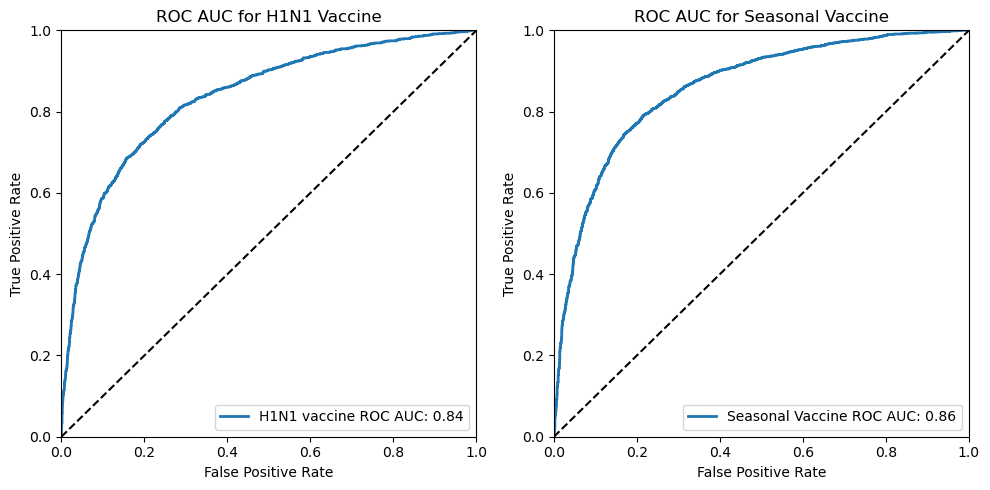

RandomForestClassifier()
_______________________________________
ROC AUC for H1N1 vaccine: 0.8237237161128994
ROC AUC for Seasonal vaccine: 0.8470018978685204
Mean ROC AUC: 0.83536280699071
Classification report for H1N1 vaccine:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      4220
           1       0.72      0.37      0.48      1122

    accuracy                           0.84      5342
   macro avg       0.78      0.66      0.69      5342
weighted avg       0.82      0.84      0.81      5342

Classification report for Seasonal vaccine:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      2917
           1       0.77      0.73      0.75      2425

    accuracy                           0.78      5342
   macro avg       0.78      0.77      0.77      5342
weighted avg       0.78      0.78      0.78      5342

************************************************************************

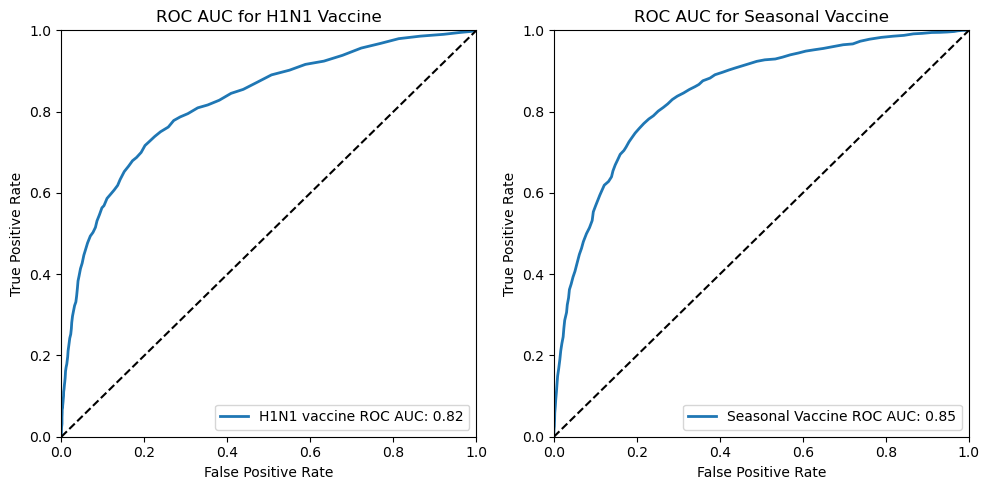

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)
_______________________________________
ROC AUC for H1N1 vaccine: 0.8242810739116845
ROC AUC for Seasonal vaccine: 0.8469017384758384
Mean ROC AUC: 0.8355914061937615
Classification report for H1N1 vaccine:
              precision    rec

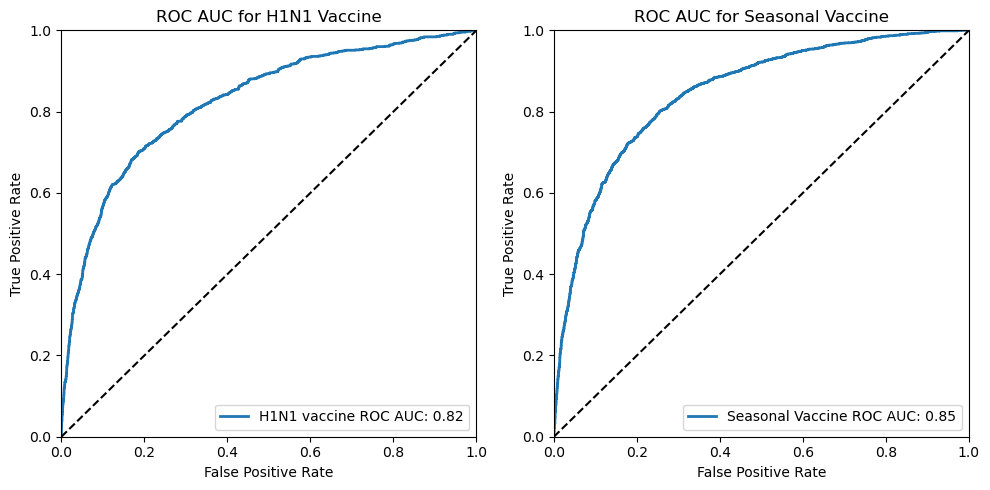

In [7]:
classifiers = [
    LogisticRegression(max_iter=1000),
    RandomForestClassifier(),
    xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
]

for model in classifiers:
#     print(model)
    classify_and_plot(model)

### 4) Feed Forward Neural Network

In [8]:
def plot_roc_curve(fpr, tpr, title):
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--')  # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)

def train_and_evaluate_model(X_train, y_train, X_test, y_test):
    target_column_names = y_train.columns
    roc_auc_scores = []
    probabilities_list = []

    for i, target_column in enumerate(target_column_names):
        # Define and compile the model
        model = Sequential([
            Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
            Dense(64, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Train the model
        history = model.fit(X_train, y_train[target_column], epochs=10, batch_size=32, validation_split=0.2)

        # Evaluate the model on test data
        evaluation = model.evaluate(X_test, y_test[target_column])
 
        # Make predictions (probabilities -- the output of the last layer)
        probabilities = model.predict(X_test).ravel()
        probabilities_list.append(probabilities)

        # Convert probabilities to binary predictions
        y_pred = (probabilities > 0.5).astype(int)

        # Calculate the ROC AUC score
        roc_auc = roc_auc_score(y_test[target_column], probabilities)
        roc_auc_scores.append(roc_auc)

        # Print accuracy
        print(f"ROC AUC for {target_column}: {roc_auc_scores[i] * 100:.2f}%")
        print(f'Classification report for {target_column}:')
        print(classification_report(y_test.iloc[:,i], y_pred))



    
    # Plot the ROC curves
    plt.figure(figsize=(10, 5))
    for i, target_column in enumerate(target_column_names):
        fpr, tpr, thresholds = roc_curve(y_test[target_column], probabilities_list[i])
        plt.subplot(1, 2, i + 1)
        plot_roc_curve(fpr, tpr, f'{target_column} ROC AUC: {roc_auc_scores[i]:.2f}')
        plt.legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()

    # Calculate and print mean ROC AUC
    mean_roc_auc = sum(roc_auc_scores) / len(roc_auc_scores)
    print(f'Mean ROC AUC: {mean_roc_auc}')
    return mean_roc_auc

Epoch 1/10
535/535 [==============================] - 1s 2ms/step - loss: 0.4154 - accuracy: 0.8224 - val_loss: 0.3941 - val_accuracy: 0.8285
Epoch 2/10
535/535 [==============================] - 1s 1ms/step - loss: 0.3843 - accuracy: 0.8379 - val_loss: 0.3946 - val_accuracy: 0.8264
Epoch 3/10
535/535 [==============================] - 1s 1ms/step - loss: 0.3732 - accuracy: 0.8402 - val_loss: 0.3951 - val_accuracy: 0.8301
Epoch 4/10
535/535 [==============================] - 1s 1ms/step - loss: 0.3644 - accuracy: 0.8448 - val_loss: 0.3928 - val_accuracy: 0.8303
Epoch 5/10
535/535 [==============================] - 1s 1ms/step - loss: 0.3535 - accuracy: 0.8480 - val_loss: 0.4021 - val_accuracy: 0.8271
Epoch 6/10
535/535 [==============================] - 1s 1ms/step - loss: 0.3448 - accuracy: 0.8545 - val_loss: 0.4081 - val_accuracy: 0.8275
Epoch 7/10
535/535 [==============================] - 1s 1ms/step - loss: 0.3305 - accuracy: 0.8577 - val_loss: 0.4192 - val_accuracy: 0.8245
Epoch 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ROC AUC for seasonal_vaccine: 83.78%
Classification report for seasonal_vaccine:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78      2917
           1       0.72      0.77      0.75      2425

    accuracy                           0.76      5342
   macro avg       0.76      0.76      0.76      5342
weighted avg       0.76      0.76      0.76      5342



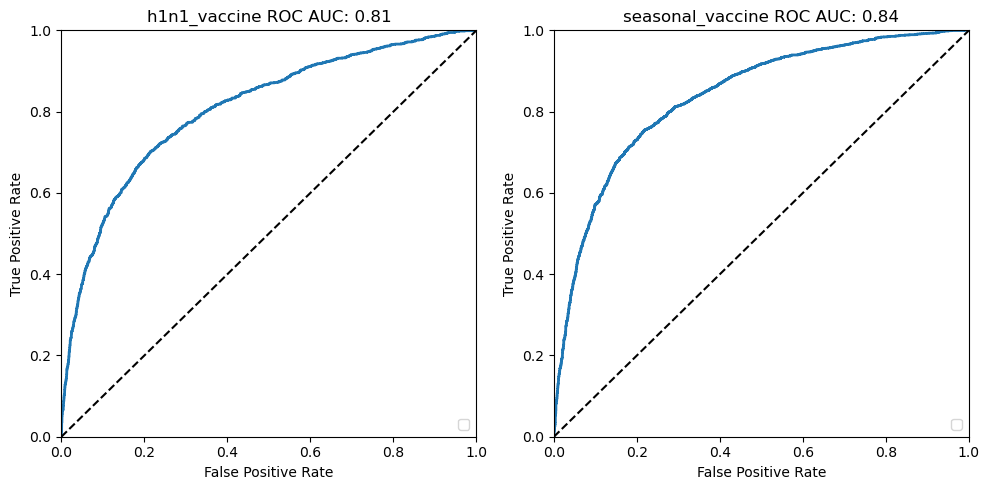

Mean ROC AUC: 0.8221668586816828


In [9]:
mean_roc_auc = train_and_evaluate_model(X_train, y_train, X_test, y_test)

### 5) Classifier Chains
- classifier chain with Logistic Regression: https://scikit-learn.org/stable/auto_examples/multioutput/plot_classifier_chain_yeast.html

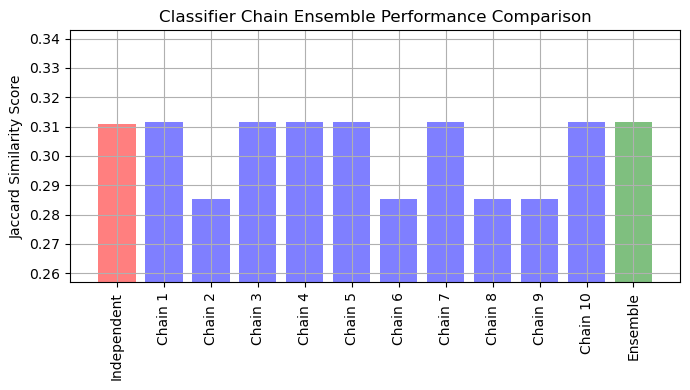

In [10]:
# Author: Adam Kleczewski(https://scikit-learn.org/stable/auto_examples/multioutput/plot_classifier_chain_yeast.html)
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import jaccard_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import ClassifierChain



# Fit an independent logistic regression model for each class using the
# OneVsRestClassifier wrapper.
base_lr = LogisticRegression()
ovr = OneVsRestClassifier(base_lr)
ovr.fit(X_train, y_train)
Y_pred_ovr = ovr.predict(X_test)
ovr_jaccard_score = jaccard_score(y_test, Y_pred_ovr, average="samples")

# Fit an ensemble of logistic regression classifier chains and take the
# take the average prediction of all the chains.
chains = [ClassifierChain(base_lr, order="random", random_state=i) for i in range(10)]
for chain in chains:
    chain.fit(X_train, y_train)

Y_pred_chains = np.array([chain.predict(X_test) for chain in chains])
chain_jaccard_scores = [
    jaccard_score(y_test, Y_pred_chain >= 0.5, average="samples")
    for Y_pred_chain in Y_pred_chains
]

Y_pred_ensemble = Y_pred_chains.mean(axis=0)
ensemble_jaccard_score = jaccard_score(
    y_test, Y_pred_ensemble >= 0.5, average="samples"
)

model_scores = [ovr_jaccard_score] + chain_jaccard_scores
model_scores.append(ensemble_jaccard_score)

model_names = (
    "Independent",
    "Chain 1",
    "Chain 2",
    "Chain 3",
    "Chain 4",
    "Chain 5",
    "Chain 6",
    "Chain 7",
    "Chain 8",
    "Chain 9",
    "Chain 10",
    "Ensemble",
)

x_pos = np.arange(len(model_names))

# Plot the Jaccard similarity scores for the independent model, each of the
# chains, and the ensemble (note that the vertical axis on this plot does
# not begin at 0).

fig, ax = plt.subplots(figsize=(7, 4))
ax.grid(True)
ax.set_title("Classifier Chain Ensemble Performance Comparison")
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation="vertical")
ax.set_ylabel("Jaccard Similarity Score")
ax.set_ylim([min(model_scores) * 0.9, max(model_scores) * 1.1])
colors = ["r"] + ["b"] * len(chain_jaccard_scores) + ["g"]
ax.bar(x_pos, model_scores, alpha=0.5, color=colors)
plt.tight_layout()
plt.show()



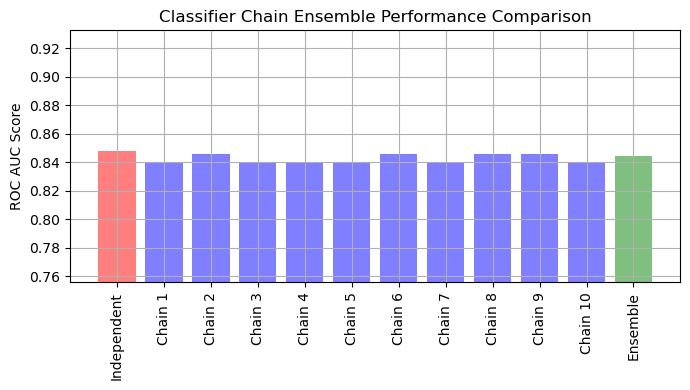

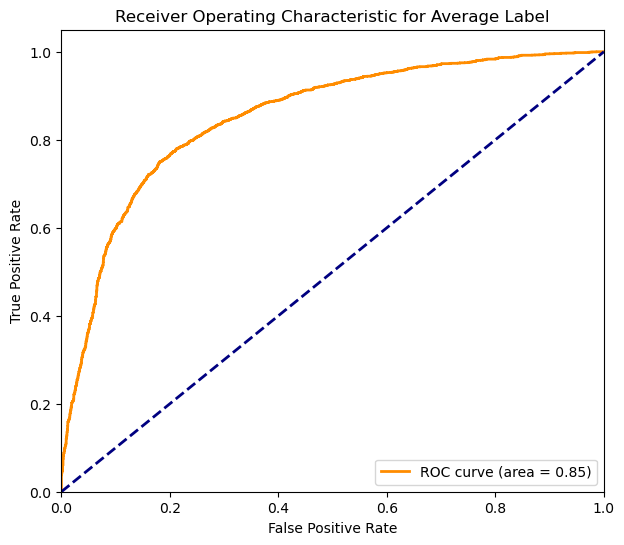

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import ClassifierChain



base_lr = LogisticRegression()
ovr = OneVsRestClassifier(base_lr)
ovr.fit(X_train, y_train)
Y_pred_prob_ovr = ovr.predict_proba(X_test)
ovr_roc_auc_score = roc_auc_score(y_test, Y_pred_prob_ovr, average="macro")

chains = [ClassifierChain(base_lr, order='random', random_state=i) for i in range(10)]
for chain in chains:
    chain.fit(X_train, y_train)

Y_pred_prob_chains = np.array([chain.predict_proba(X_test) for chain in chains])
chain_roc_auc_scores = [
    roc_auc_score(y_test, Y_pred_prob_chain, average="macro")
    for Y_pred_prob_chain in Y_pred_prob_chains
]

Y_pred_prob_ensemble = Y_pred_prob_chains.mean(axis=0)
ensemble_roc_auc_score = roc_auc_score(
    y_test, Y_pred_prob_ensemble, average="macro"
)

model_scores = [ovr_roc_auc_score] + chain_roc_auc_scores
model_scores.append(ensemble_roc_auc_score)

model_names = (
    ['Independent'] + [f'Chain {i+1}' for i in range(10)] + ['Ensemble']
)

x_pos = np.arange(len(model_names))

fig, ax = plt.subplots(figsize=(7, 4))
ax.grid(True)
ax.set_title("Classifier Chain Ensemble Performance Comparison")
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation='vertical')
ax.set_ylabel("ROC AUC Score")
ax.set_ylim([min(model_scores) * 0.9, max(model_scores) * 1.1])
colors = ['r'] + ['b'] * 10 + ['g']
ax.bar(x_pos, model_scores, alpha=0.5, color=colors)
plt.tight_layout()
plt.show()

# Calculate the average predicted probability across all labels for each instance
average_pred_prob = Y_pred_prob_ensemble.mean(axis=1)

# Calculate the true binary label for each instance (1 if any label is positive, else 0)
binary_true_label = y_test.any(axis=1)

# Compute ROC AUC score
average_roc_auc = roc_auc_score(binary_true_label, average_pred_prob)

# Compute ROC curve
fpr, tpr, _ = roc_curve(binary_true_label, average_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % average_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Average Label')
plt.legend(loc="lower right")
plt.show()

### Fine tuning Xgboost
- We used GridSearchCV for hyperparameter tuning

In [28]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier

xgb_model = XGBClassifier(objective='binary:logistic')

multioutput_model = MultiOutputClassifier(xgb_model)

param_grid = {
    'estimator__learning_rate': [0.01, 0.1, 0.5],
    'estimator__max_depth': [3, 5, 7],
    'estimator__n_estimators': [50, 100, 200],
}

grid_search = GridSearchCV(estimator=multioutput_model, param_grid=param_grid, cv=3, scoring='f1_micro')

grid_search.fit(X_train, y_train)  # X_train is your input features, y_train is the multilabel target

best_model = grid_search.best_estimator_

best_model.fit(X_train, y_train)

predictions = best_model.predict(X_test)

prediction_probs = best_model.predict_proba(X_test)


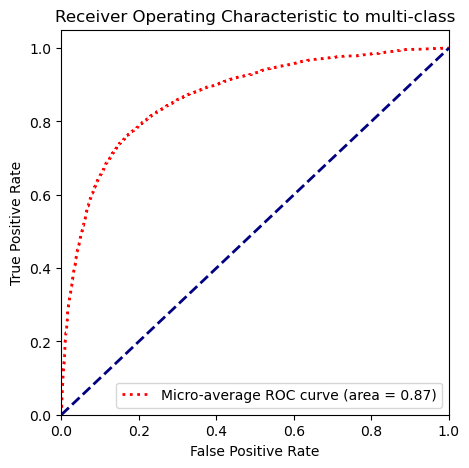

Average ROC AUC score: 0.87


In [29]:
def plot_multilabel_roc(y_test, prediction_probs):
    n_classes = y_test.shape[1]
    fig, ax = plt.subplots(figsize=(5, 5))

    prediction_probs_combined = np.vstack([probs[:, 1] for probs in prediction_probs]).T

    roc_auc_list = []
    for i in range(n_classes):
        fpr, tpr, thresholds = roc_curve(y_test.iloc[:, i], prediction_probs_combined[:, i])
        roc_auc = auc(fpr, tpr)
        roc_auc_list.append(roc_auc)
#         ax.plot(fpr, tpr, lw=2, label=f'ROC curve of class {i} (area = {roc_auc:.2f})')

    fpr, tpr, _ = roc_curve(y_test.to_numpy().ravel(), prediction_probs_combined.ravel())
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, color='red', lw=2, linestyle=':', label=f'Micro-average ROC curve (area = {roc_auc:.2f})')

    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    ax.set(xlim=[0.0, 1.0], ylim=[0.0, 1.05], title="Receiver Operating Characteristic to multi-class")
    ax.legend(loc="lower right")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
    average_roc_auc = np.mean(roc_auc_list)
    print(f'Average ROC AUC score: {roc_auc:.2f}')
plot_multilabel_roc(y_test, prediction_probs)

### 6 and 7 Models
- Ridge Classifier: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html
- Extra Tree Classifier: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html

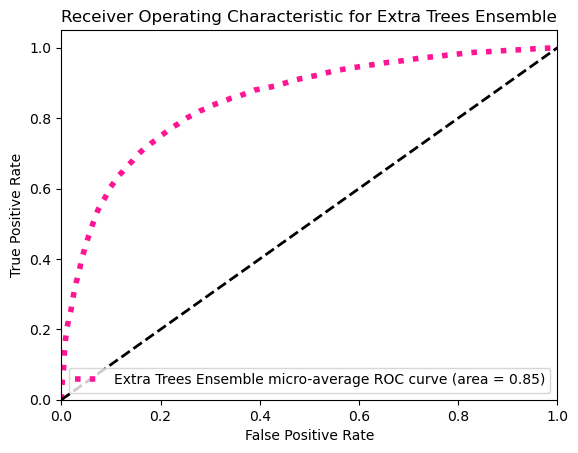

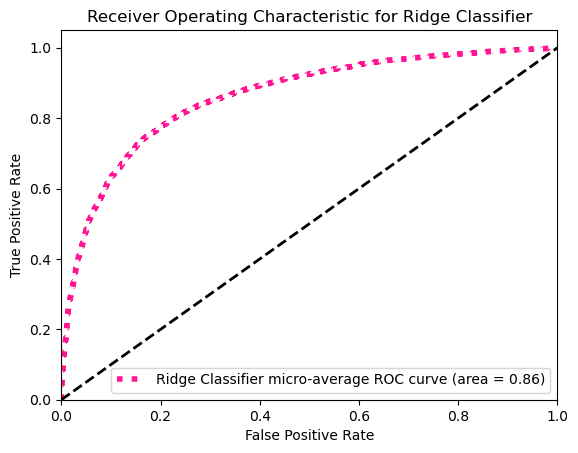

In [31]:
from sklearn.linear_model import RidgeClassifier
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt

n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

classifiers = [
    ('Extra Trees Ensemble', ExtraTreesClassifier()),
    ('Ridge Classifier', RidgeClassifier()),
]

roc_auc_dict = {}

y_test_np = y_test.values if isinstance(y_test, pd.DataFrame) else y_test

for name, classifier in classifiers:
    clf = OneVsRestClassifier(classifier)
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
#     print(f"Classification report for {name}:\n")
#     print(classification_report(y_test_np, y_pred, target_names=[f'Class {i}' for i in range(n_classes)]))

    y_pred_prob = clf.predict_proba(X_test) if hasattr(clf, "predict_proba") else clf.decision_function(X_test)
    if y_pred_prob.ndim == 1:  # If y_pred_prob is one-dimensional, reshape it
        y_pred_prob = y_pred_prob.reshape(-1, 1)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_np[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_np.ravel(), y_pred_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    roc_auc_dict[name] = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc}

    plt.figure()
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'{name} micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
             color='deeppink', linestyle=':', linewidth=4)
    
#     for i in range(n_classes):
#         plt.plot(fpr[i], tpr[i], lw=lw,
#                  label=f'{name} ROC curve of class {i} (area = {roc_auc[i]:0.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {name}')
    plt.legend(loc="lower right")
    plt.show()
